In [1]:
import yfinance
import numpy as np
import pandas as pd

TICKER = "INFY"
data = yfinance.download(TICKER+".NS", period="8mo")

[*********************100%***********************]  1 of 1 completed


In [37]:
def percent_k(df):
    K = 14
    n_period = K-1
    maxlen = df.shape[0]
    k = {}
    
    for i in range(n_period, maxlen):
        curr_price = df.iloc[i]['Close']
        hh = max(df.iloc[i-n_period:i+1]['High'].values)
        ll = min(df.iloc[i-n_period:i+1]['Low'].values)
        pk = ((curr_price-ll)/(hh-ll))*100
        k[i] = pk
    
    return k

def percent_d(k):
    keys = sorted(k.keys())
    maxlen = len(keys)
    i = 2
    d = {}
    while i < maxlen:
        avg = (k[keys[i-2]] + k[keys[i-1]] + k[keys[i]])/3
        d[keys[i]] = avg
        i += 1
    
    return d

def buySignal(k,k1,d,d1):
    return (k > d) and (k1 < d1)

def sellSignal(k,k1,d,d1):
    return (k < d) and (k1 > d1)

In [51]:
from random import randint
import random

random.seed(10)

shares_bought = 0
shares_sold = 0
shares = 0
history = []
profit = 0
overbought, oversold = 80,20
totalBuy, totalSell = 0,0

k = percent_k(data)
d = percent_d(k)

for i in range(data.shape[0]):
    if i in k.keys() and i in d.keys() and (i-1) in d.keys():
        #oversold condition
        if k[i] <= 20:
            if buySignal(k[i], k[i-1], d[i], d[i-1]):
                buy_shares = randint(1,10)
                curr_price = data.iloc[i]['Low']
                totalBuy += curr_price*buy_shares
                shares += buy_shares
                shares_bought += buy_shares
                history.append((i, data.iloc[i].name, 'buy', buy_shares, shares))
        #overbought condition
        elif k[i] >= 80:
            if sellSignal(k[i], k[i-1], d[i], d[i-1]):
                if shares > 0:
                    sell_shares = randint(1, shares)
                    curr_price = data.iloc[i]['Low']
                    totalSell += curr_price*sell_shares
                    shares -= sell_shares
                    shares_sold += sell_shares
                    history.append((i, data.iloc[i].name, 'sell', sell_shares, shares))

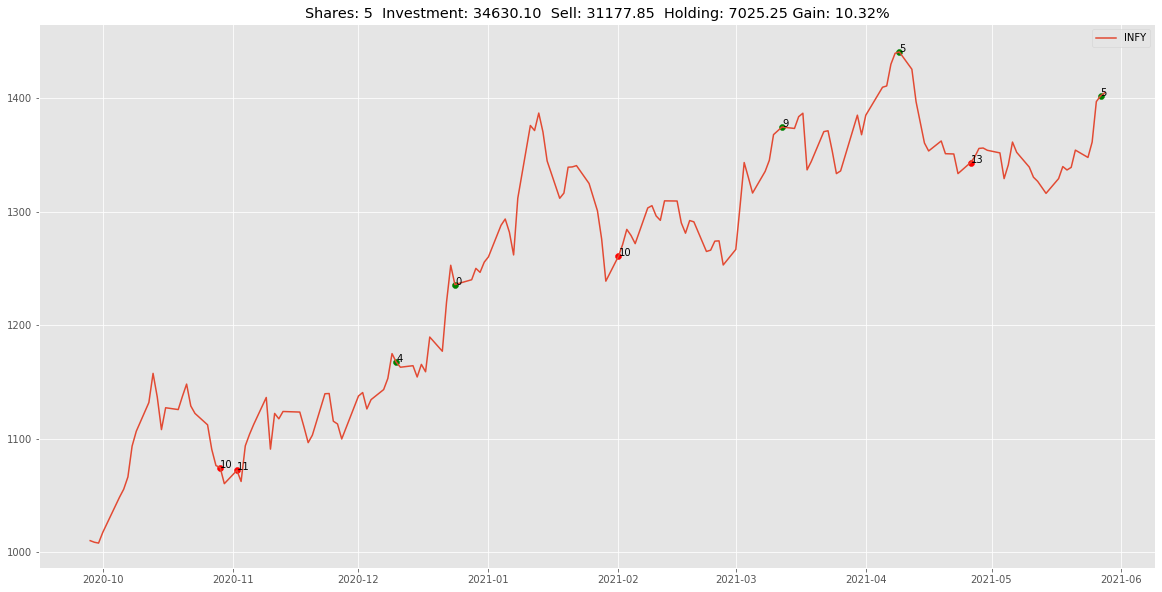

In [52]:
import matplotlib.pyplot as plt

buy_plot = np.array([[h[1], data.iloc[h[0]]['Close'], h[-1]] for h in history if h[2] == 'buy'])
sell_plot = np.array([[h[1], data.iloc[h[0]]['Close'], h[-1]] for h in history if h[2] == 'sell'])
holding = shares*data.iloc[-1]['Close']

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(data['Close'].index, data['Close'].values, label=TICKER)
plt.scatter(buy_plot[:,0], buy_plot[:,1], c='red')
for i,s in enumerate(buy_plot[:,2]):
    plt.annotate(str(s), (buy_plot[i,0],buy_plot[i,1]))
plt.scatter(sell_plot[:,0], sell_plot[:,1], c='green')
for i,s in enumerate(sell_plot[:,2]):
    plt.annotate(str(s), (sell_plot[i,0],sell_plot[i,1]))
plt.title(f"Shares: {shares}  Investment: {totalBuy:.2f}  Sell: {totalSell:.2f}  Holding: {holding:.2f} Gain: {(holding+totalSell-totalBuy)/totalBuy*100:.2f}%")
plt.legend()
plt.show()